# BO comparisons in 1D

Now I've made a modular implementation of a BO loop using BoTorch. Next, I'll compare many acquisition functions in different settings, focusing on 1D functions in this notebook. 

# Standard acquisition functions

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch

from molbo.acquisition import *
from molbo.bo import BOLoop, BOMetrics
from molbo.models import GPModel
from molbo.utils.functions import Toy1DFunction
from molbo.utils.logger import WandBLogger

sns.set_style("whitegrid")
sns.set_palette("muted")


device = "cuda" if torch.cuda.is_available() else "cpu"
DTYPE = torch.float64
t_params = {
    'device': device,
    'dtype': DTYPE,
}

print(f"Device: {device}\nData type: {DTYPE}")

/home/wvir/miniconda3/envs/molbo/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/wvir/miniconda3/envs/molbo/lib/python3.11/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/home/wvir/miniconda3/envs/molbo/lib/python3.11/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' a

Device: cpu
Data type: torch.float64


In [2]:
def run_experiment(acq, n_trials: int = 5):

    for i in range(n_trials):

        run_name = f"{acq.__name__}_trial_{i+1}"

        logger = WandBLogger(
            project_name="molbo",
            group_name=acq.__name__,
            run_name=run_name,
        )

        f = Toy1DFunction()
        bounds = f.bounds

        # Generate 3 random samples
        n_init = 3
        train_X = bounds[1] * torch.rand(n_init, 1, **t_params)
        train_y = f(train_X).unsqueeze(-1)

        model = GPModel(train_X, train_y)
        metrics = BOMetrics(f_max = f.max, logger=logger)
        bo_loop = BOLoop(model, acq, f, metrics=metrics)
        bo_loop.run(n_iters=10)

        logger.finish()

    return metrics

In [3]:
acquisition_funcs = [EI, LogEI, PI, LogPI, UCB, ThompsonSampling]

In [4]:
metrics = []
for acq in acquisition_funcs:
    print(f"Running experiment with acquisition function: {acq.__name__}")
    metrics.append(run_experiment(acq))

Running experiment with acquisition function: EI
Running experiment with acquisition function: LogEI
Running experiment with acquisition function: PI
Running experiment with acquisition function: LogPI
Running experiment with acquisition function: UCB
Running experiment with acquisition function: ThompsonSampling


In [5]:
ei_results = metrics[0].compute_metrics()
log_ei_results = metrics[1].compute_metrics()
pi_results = metrics[2].compute_metrics()
log_pi_results = metrics[3].compute_metrics()
ucb_results = metrics[4].compute_metrics()
ts_results = metrics[5].compute_metrics()

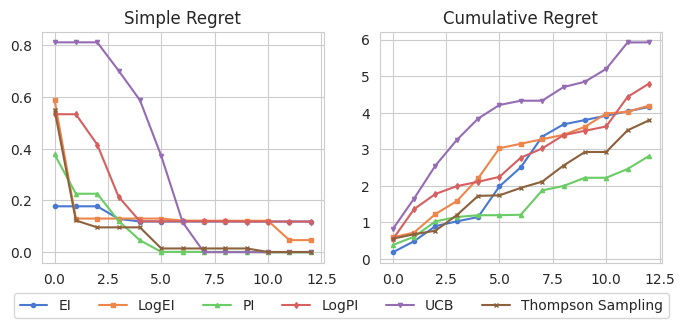

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))

markersize= 3

# Plot simple regrets
ax = axes[0]

ax.plot(ei_results['simple_regret'], marker='o', markersize=markersize, label="EI")
ax.plot(log_ei_results['simple_regret'], marker='s', markersize=markersize, label="LogEI")
ax.plot(pi_results['simple_regret'], marker='^', markersize=markersize, label="PI")
ax.plot(log_pi_results['simple_regret'], marker='d', markersize=markersize, label="LogPI")
ax.plot(ucb_results['simple_regret'], marker='v', markersize=markersize, label="UCB")
ax.plot(ts_results['simple_regret'], marker='x', markersize=markersize, label="Thompson Sampling")

ax.set_title("Simple Regret")


# Plot cumulative regrets
ax = axes[1]

ax.plot(ei_results['cumulative_regret'], marker='o', markersize=markersize, label="EI")
ax.plot(log_ei_results['cumulative_regret'], marker='s', markersize=markersize, label="LogEI")
ax.plot(pi_results['cumulative_regret'], marker='^', markersize=markersize, label="PI")
ax.plot(log_pi_results['cumulative_regret'], marker='d', markersize=markersize, label="LogPI")
ax.plot(ucb_results['cumulative_regret'], marker='v', markersize=markersize, label="UCB")
ax.plot(ts_results['cumulative_regret'], marker='x', markersize=markersize, label="Thompson Sampling")

ax.set_title("Cumulative Regret")

ax.legend(bbox_to_anchor=(1.05, -0.1), ncols=6);

In [ ]:
# TODO:
# * plot 1d
# * plot regret
# * plot compute (time for BO iteration?)
# * plot model loss